# Dynamics in the mapped space $[0,1]$

Now we don't bin the neurons, we directly simulate the integral in $[0,1]$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.colors as mplcolors
import numpy as np
from scipy import stats
from neurodyn import *

## Integral formulation

### Testing the integral formulation

In [3]:
# TODO : this needs to be harmonized with the LowRankRNNParams.new_valentin function (this is just a copy-paste)

def rho(z):
	"""R^p PDF
	
	Parameters
	----------
	z : np.ndarray of shape (N, p)
		position in R^p

	Returns
	-------
	np.ndarray of shape (N,)
		values of the PDF at the points ``z``
	"""
	return 1/np.sqrt(2*np.pi)*np.exp(-np.linalg.norm(z, axis=1)**2/2)

def phi(z):
	return sigmoid(z)

z0 = np.random.default_rng(42).normal(loc=0, scale=1, size=1_000_000)
phi_z0 = phi(z0)
a, c = np.mean(phi_z0), np.var(phi_z0)

def phi_tilde(z):
	return (phi(z) - a) / c

def w(z, y):
	"""Connectivity kernel from position ``y`` to ``z``
	
	Parameters
	----------
	z : np.ndarray of shape (N, p)
		receiving position in R^p
	y : np.ndarray of shape (N, p)
		emitting position in R^p

	Returns
	-------
	np.ndarray of shape (N,)
		values of the connectivity kernel between ``y`` and ``z``
	"""
	return (phi_tilde(y) * z).sum(axis=1)

In [4]:
def compute_J_ab_integral_naive(mapping, Z):
	# slow way
	J = np.zeros((mapping.num_bins, mapping.num_bins))

	for beta in range(mapping.num_bins):
		for alpha in range(mapping.num_bins):
			J[alpha, beta] += w(Z[alpha][None, :], Z[beta][None, :])
		J[:, beta] *= rho(Z[beta][None, :])

	J /= rho(Z).sum()
	return J

def compute_J_ab_integral_naive2(mapping, Z):
	J = np.zeros((mapping.num_bins, mapping.num_bins))

	for beta in range(mapping.num_bins):
		J[:, beta] += w(Z, Z[beta][None, :]) * rho(Z[beta][None, :])

	J /= rho(Z).sum()  # renormalize
	return J

def compute_J_ab_integral(mapping, Z):
	return np.einsum('im,jm,j->ij', Z, phi_tilde(Z), rho(Z)) / rho(Z).sum()

def compute_J_ab_integral_lowrank(mapping, Z):
	return LowRankRNNParams(
		phi=sigmoid, I_ext=zero, exclude_self_connections=False,
		# NOTE : we need to scale by mapping.num_bins, because the to_dense() method divides by N=num_bins again
		F=Z, G=phi_tilde(Z) * rho(Z)[:, None]/rho(Z).sum() * mapping.num_bins
	).to_dense().J

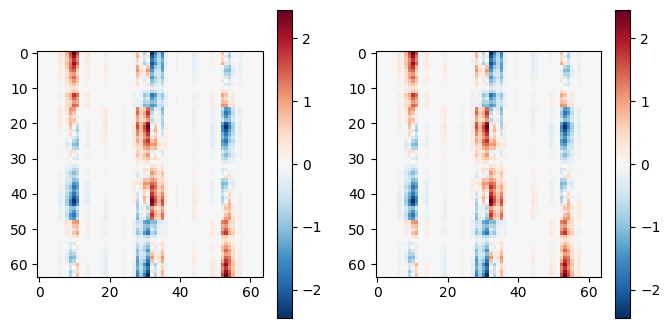

In [5]:
mapping = RecursiveLocalMapping(nrec=3)
Z = mapping.inverse_samples(bbox=Box(xmin=-4, xmax=4, ymin=-4, ymax=4), centered=True)
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
_ = ax[0].imshow(compute_J_ab_integral(mapping, Z), cmap='RdBu_r')
fig.colorbar(_, ax=ax[0])
_ = ax[1].imshow(compute_J_ab_integral_lowrank(mapping, Z), cmap='RdBu_r')
fig.colorbar(_, ax=ax[1])
plt.show()

In [14]:
mapping = RecursiveLocalMapping(nrec=1)
Z = mapping.inverse_samples(bbox=Box(xmin=-4, xmax=4, ymin=-4, ymax=4))

print('-- naive method --')
print(compute_J_ab_integral_naive(mapping, Z))

print('-- naive method 2 --')
print(compute_J_ab_integral_naive2(mapping, Z))

print('-- fast einsum method --')
print(compute_J_ab_integral(mapping, Z))

print('-- low rank method --')
print(compute_J_ab_integral_lowrank(mapping, Z))

-- naive method --
[[ 8.77802046e+00  6.68166413e-04 -8.77668412e+00  6.68166413e-04]
 [ 0.00000000e+00  8.77735229e+00  0.00000000e+00 -8.77735229e+00]
 [-8.77802046e+00 -6.68166413e-04  8.77668412e+00 -6.68166413e-04]
 [ 0.00000000e+00 -8.77735229e+00  0.00000000e+00  8.77735229e+00]]
-- naive method 2 --
[[ 8.77802046e+00  6.68166413e-04 -8.77668412e+00  6.68166413e-04]
 [ 0.00000000e+00  8.77735229e+00  0.00000000e+00 -8.77735229e+00]
 [-8.77802046e+00 -6.68166413e-04  8.77668412e+00 -6.68166413e-04]
 [ 0.00000000e+00 -8.77735229e+00  0.00000000e+00  8.77735229e+00]]
-- fast einsum method --
[[ 8.77802046e+00  6.68166413e-04 -8.77668412e+00  6.68166413e-04]
 [ 0.00000000e+00  8.77735229e+00  0.00000000e+00 -8.77735229e+00]
 [-8.77802046e+00 -6.68166413e-04  8.77668412e+00 -6.68166413e-04]
 [ 0.00000000e+00 -8.77735229e+00  0.00000000e+00  8.77735229e+00]]
-- low rank method --
[[ 8.77802046e+00  6.68166413e-04 -8.77668412e+00  6.68166413e-04]
 [ 0.00000000e+00  8.77735229e+00  0.00

simulating LowRankRNN{N=100000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:05<00:00]
simulating LowRankRNN{N=4, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=16, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=64, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=256, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=1024, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=4096, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:01<00:00]


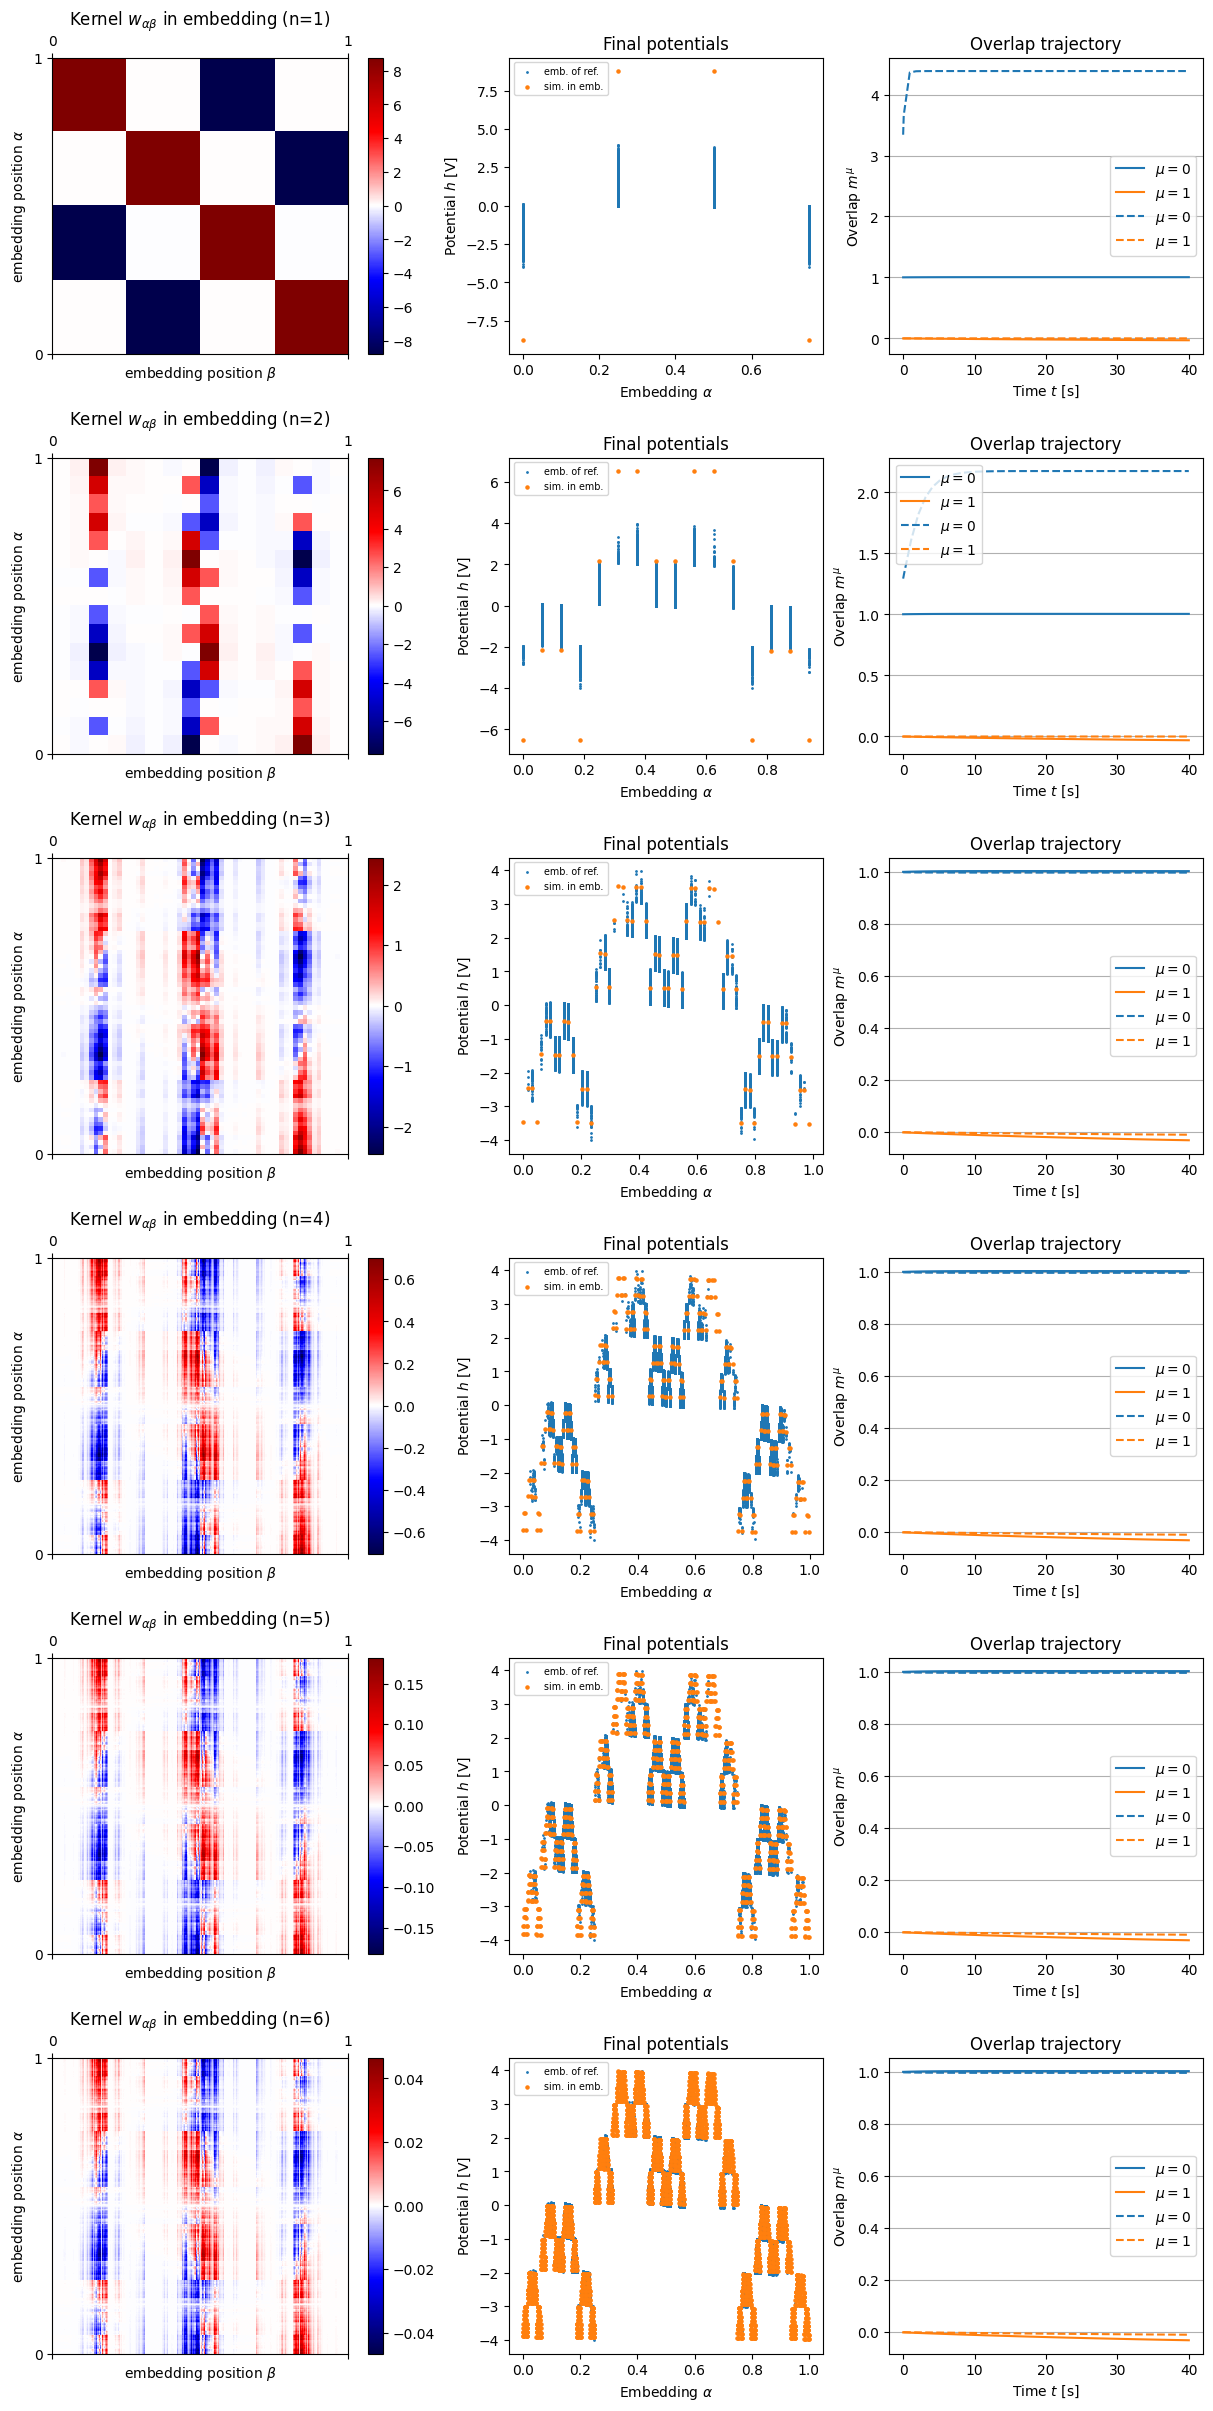

In [17]:
# NOTE : we start from the pattern h(0)=xi^0, because the h(0)=0 condition is a bit a weird fixed point
rnn_ref = LowRankRNN.new_valentin(p=2, N=100_000, phi=sigmoid, I_ext=zero, exclude_self_connections=False)
# Initial conditions mu=0
res_ref = rnn_ref.simulate(h0=rnn_ref.F[:, 0], t_span=(0, 40), dt_max=1, progress=True)
# Initial conditions h=0
# res_ref = rnn_ref.simulate(h0=np.zeros(rnn_ref.N), t_span=(0, 40), dt_max=1, progress=True)

# ns = [1,2]
# ns = [1, 2, 3]
# ns = [1, 2, 3, 4]
ns = [1, 2, 3, 4, 5, 6]
fig, axes = plt.subplots(ncols=3, nrows=len(ns), figsize=(3*4, len(ns)*4), constrained_layout=True)

bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)  # the bbox to run the embedded simulation in

for ax, n in zip(axes, ns):
	mapping = RecursiveLocalMapping(nrec=n)
	Z = mapping.inverse_samples(bbox=Box(xmin=-4, xmax=4, ymin=-4, ymax=4))
	# J = compute_J_ab_integral(mapping, Z)

	# rnn_emb = DenseRNN(DenseRNNParams(phi=sigmoid, I_ext=zero, exclude_self_connections=False, J=J))
	# res_emb = rnn_emb.simulate(h0=Z[:, 0], t_span=(0, 40), dt_max=1, progress=True)
	# res_emb = rnn_emb.simulate(h0=np.zeros(mapping.num_bins), t_span=(0, 40), dt_max=1, progress=True)
	rnn_emb = LowRankRNN(LowRankRNNParams(
		phi=sigmoid, I_ext=zero, exclude_self_connections=False,
		# NOTE : we need to scale by mapping.num_bins, because the to_dense() method divides by N=num_bins again
		F=Z, G=phi_tilde(Z) * rho(Z)[:, None]/rho(Z).sum() * mapping.num_bins
	))
	res_emb = rnn_emb.simulate(h0=Z[:, 0], t_span=(0, 40), dt_max=1, progress=True)

	ax[0].set_title(f'Kernel $w_{{\\alpha\\beta}}$ in embedding (n={mapping.nrec})')
	ax[0].set_xlabel('embedding position $\\beta$')
	ax[0].set_ylabel('embedding position $\\alpha$')
	im = ax[0].matshow(rnn_emb.params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
	fig.colorbar(im, ax=ax[0])

	mask = bbox.contains(rnn_ref.F)  # WARNING : we need to have the same bounding box for the sampled RNN, and the integral formulation !
	ax[1].set_xlabel('Embedding $\\alpha$')
	ax[1].set_ylabel('Potential $h$ [V]')
	ax[1].set_title('Final potentials')
	ax[1].scatter(mapping(rnn_ref.F[mask], bbox=bbox), res_ref.h[mask, -1], s=1, label='emb. of ref.')
	ax[1].scatter(mapping(Z, bbox=bbox), res_emb.h[:, -1], s=5, label='sim. in emb.')
	ax[1].legend(loc='upper left', fontsize='x-small')

	plot_overlap_trajectory(rnn_ref, res_ref, figax=(fig, ax[2]))
	ax[2].set_prop_cycle(None)  # reset color cycle
	m = np.einsum('am,a...,a->m...', phi_tilde(Z), phi(res_emb.h), rho(Z)/rho(Z).sum())
	for mu in range(len(m)):
		ax[2].plot(res_emb.t, m[mu], label=f'$\\mu={mu}$', linestyle='--')
	ax[2].legend()

## Connectivity of the different mappings

simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=16, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=16, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=16, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulat

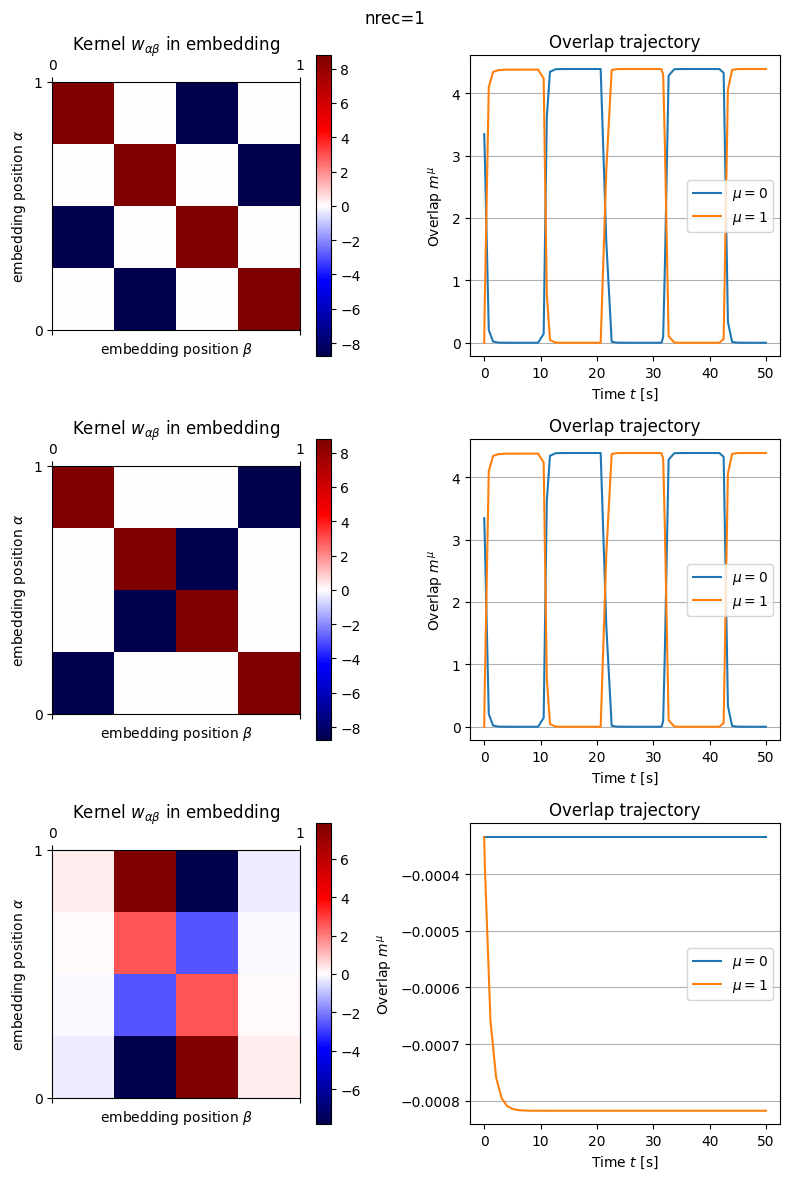

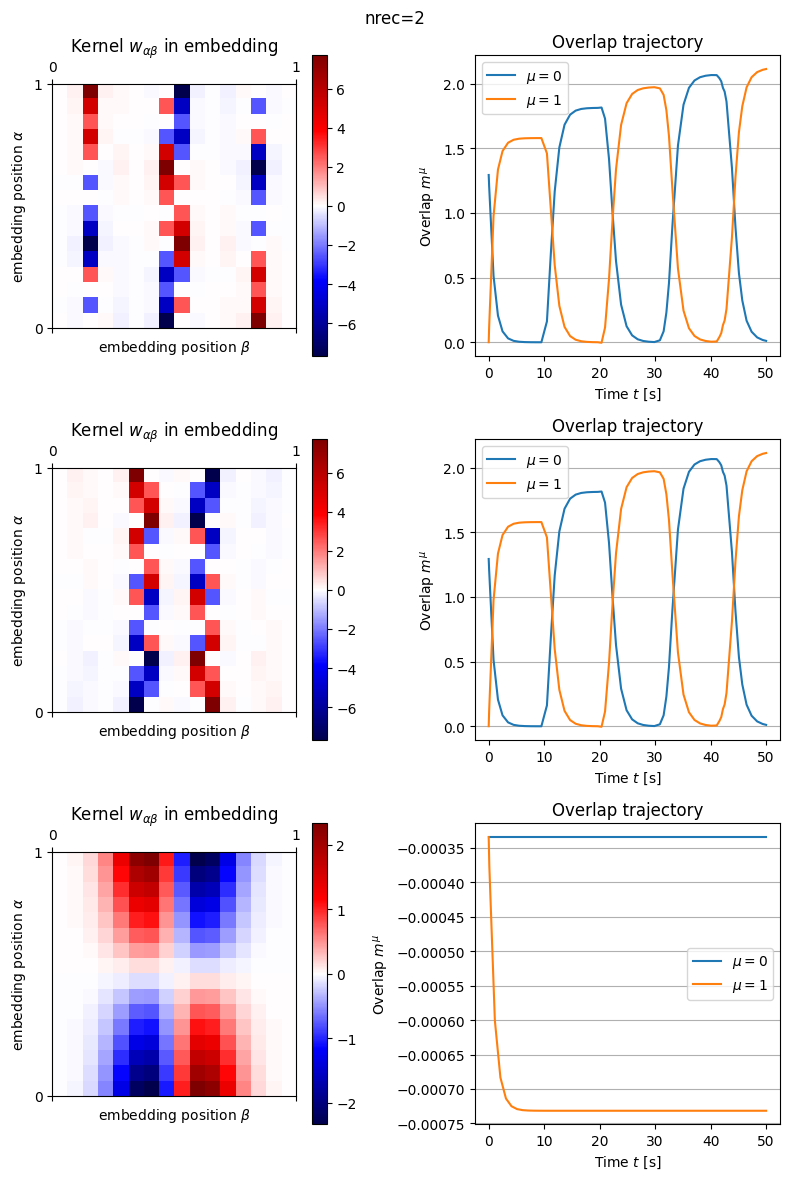

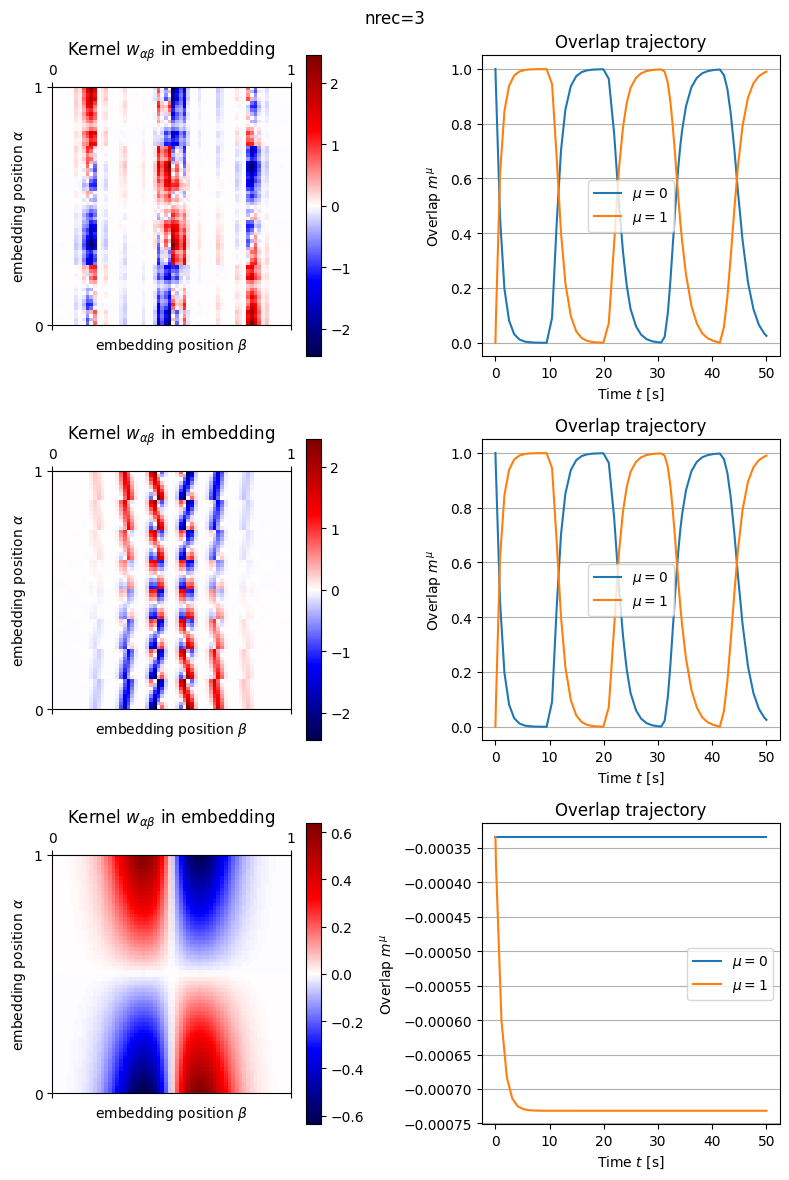

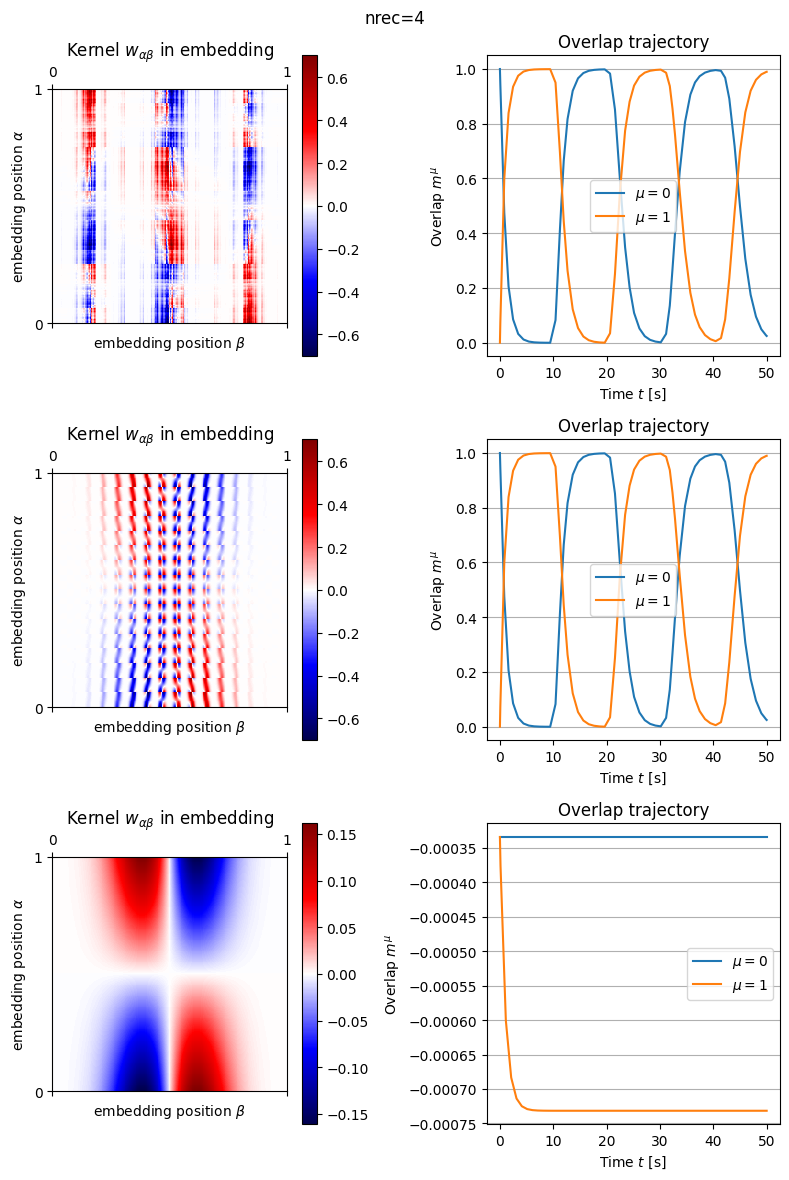

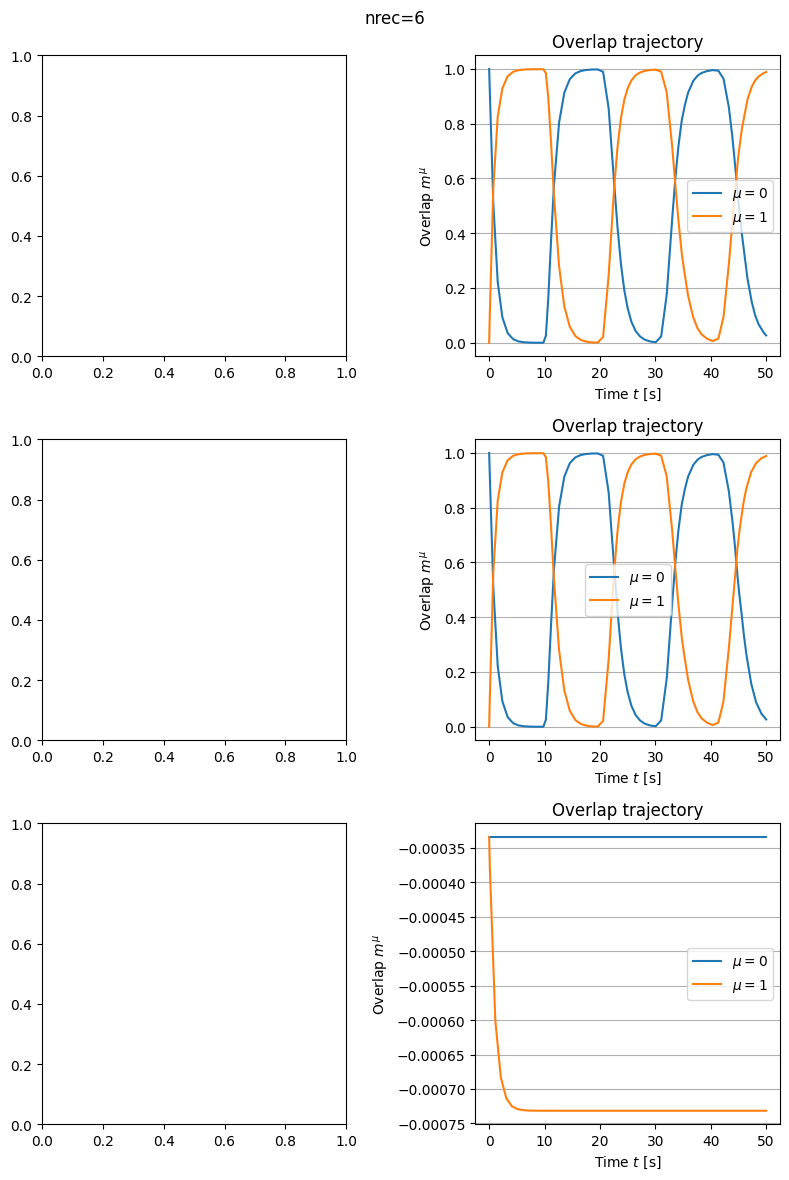

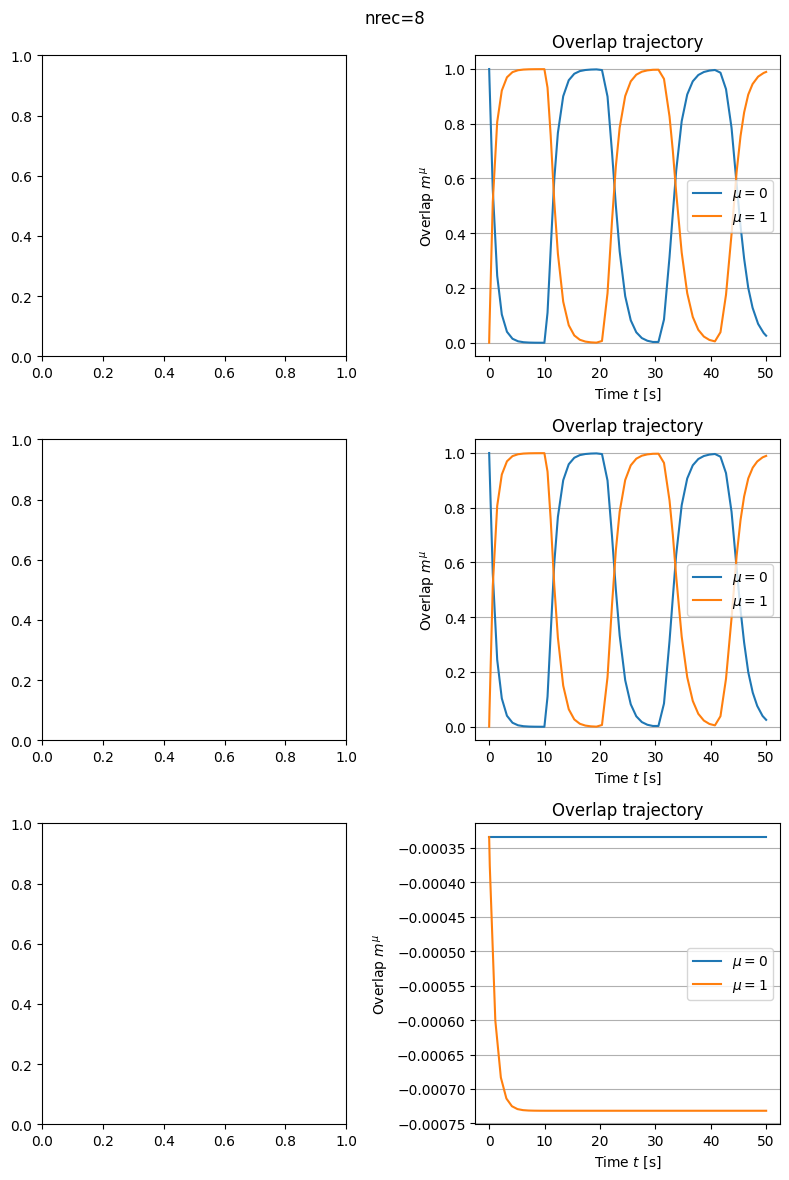

In [76]:
nrecs = [1,2,3,4,6,8]

for nrec in nrecs:
	mappings = {
		'reclocal': RecursiveLocalMapping(nrec=nrec),
		'reshape': ReshapeMapping(nx=2**nrec, ny=2**nrec),
		'reshapey': ReshapeMapping(nx=1, ny=4**nrec),
	}

	bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)

	fig, axes = plt.subplots(nrows=len(mappings), ncols=2, figsize=(2*4, len(mappings)*4), layout='tight')

	for (name, mapping), ax in zip(mappings.items(), axes):
		Z = mapping.inverse_samples(bbox)
		params = LowRankCyclingRNNParams(
			phi=sigmoid, I_ext=zero, exclude_self_connections=False,
			# NOTE : we need to scale by mapping.num_bins, because the to_dense() method divides by N=num_bins again
			F=Z, G=phi_tilde(Z) * rho(Z)[:, None]/rho(Z).sum() * mapping.num_bins,
			delta=10, shift=1,
		)

		if nrec <= 4:
			J = params.to_dense().J
			ax[0].set_title(f'Kernel $w_{{\\alpha\\beta}}$ in embedding')
			ax[0].set_xlabel('embedding position $\\beta$')
			ax[0].set_ylabel('embedding position $\\alpha$')
			im = ax[0].matshow(J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
			fig.colorbar(im, ax=ax[0])

		rnn = LowRankCyclingRNN(params)
		res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 50), dt_max=1, progress=True)
		plot_overlap_trajectory(rnn, res, figax=(fig, ax[1]))

		fig.suptitle(f'nrec={nrec}')

## averaging the mapped connectivity

### cacxa

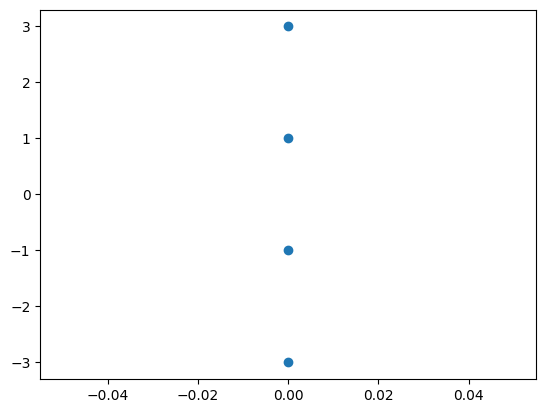

simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]


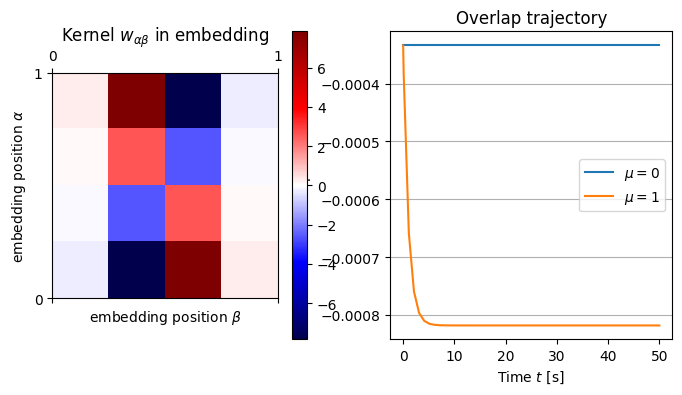

In [194]:
nrec = 2

mapping = ReshapeMapping(nx=1, ny=2**nrec)
bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)

Z = mapping.inverse_samples(bbox)
params = LowRankCyclingRNNParams(
	phi=sigmoid, I_ext=zero, exclude_self_connections=False,
	# NOTE : we need to scale by mapping.num_bins, because the to_dense() method divides by N=num_bins again
	F=Z, G=phi_tilde(Z) * rho(Z)[:, None]/rho(Z).sum() * mapping.num_bins,
	delta=10, shift=1,
)

J = params.to_dense().J
J_caca = J.copy()

plt.scatter(*params.F.T)
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].set_title(f'Kernel $w_{{\\alpha\\beta}}$ in embedding')
ax[0].set_xlabel('embedding position $\\beta$')
ax[0].set_ylabel('embedding position $\\alpha$')
im = ax[0].matshow(J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
fig.colorbar(im, ax=ax[0])

rnn = LowRankCyclingRNN(params)
res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 50), dt_max=1, progress=True)
plot_overlap_trajectory(rnn, res, figax=(fig, ax[1]));

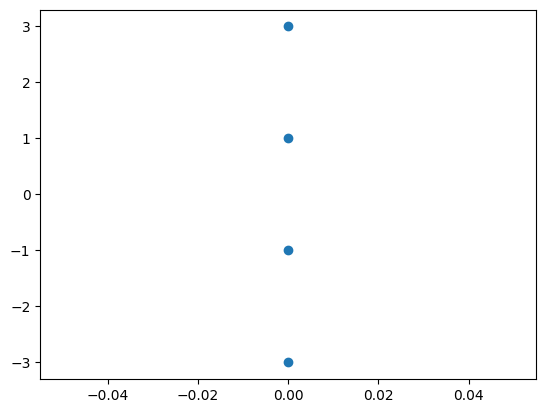

simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]


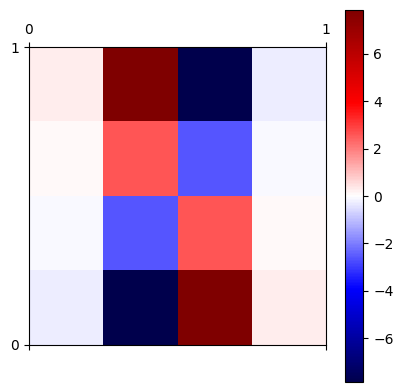

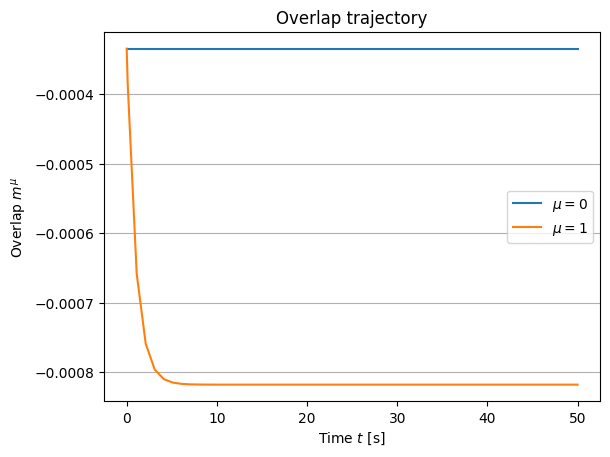

In [195]:
F_avg = np.zeros((2**nrec, 2))

for i in range(2**nrec):
	# F_avg[i] = rnn.F[i*2**nrec:(i+1)*2**nrec, :].mean(axis=0)
	F_avg[i] = rnn.F[i::2**nrec].mean(axis=0)

G_avg = np.zeros((2**nrec, 2))

for i in range(2**nrec):
	# G_avg[i] = rnn.G[i*2**nrec:(i+1)*2**nrec, :].mean(axis=0)
	G_avg[i] = rnn.G[i::2**nrec].mean(axis=0)

# apparently equivalent
# J_avg = np.zeros((2**nrec, 2**nrec), dtype=float)
# for i in range(2**nrec):
# 	for j in range(2**nrec):
# 		# NOTE : we don't need to reweigh by rho here, because J is already reweighted !
# 		J_avg[i,j] = J[i*2**nrec:(i+1)*2**nrec, j*2**nrec:(j+1)*2**nrec].mean()
# J_avg *= 2**nrec  # scale because we have averaged 2**nrec neurons together !
# OR
J_avg = np.einsum('im,jm->ij', F_avg, G_avg) / 2**nrec  # idk

plt.scatter(*F_avg.T)
plt.show()

plt.matshow(J_avg, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
plt.colorbar()

rnn_avg = LowRankCyclingRNN(LowRankCyclingRNNParams(phi=sigmoid, I_ext=zero, exclude_self_connections=False, F=F_avg, G=G_avg, delta=10, shift=1))
res_avg = rnn_avg.simulate(h0=F_avg[:, 0], t_span=(0, 50), dt_max=1, progress=True)
plot_overlap_trajectory(rnn_avg, res_avg);

### prout

simulating LowRankCyclingRNN{N=4096, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:01<00:00]


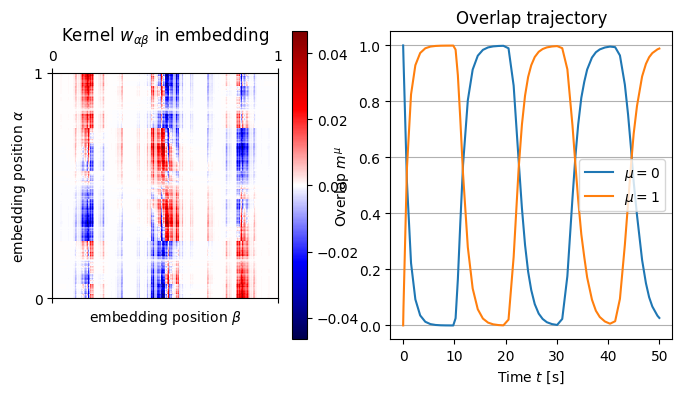

In [233]:
nrec = 6

mapping = RecursiveLocalMapping(nrec=nrec)
bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)

Z = mapping.inverse_samples(bbox)
params = LowRankCyclingRNNParams(
	phi=sigmoid, I_ext=zero, exclude_self_connections=False,
	# NOTE : we need to scale by mapping.num_bins, because the to_dense() method divides by N=num_bins again
	F=Z, G=phi_tilde(Z) * rho(Z)[:, None]/rho(Z).sum() * mapping.num_bins,
	delta=10, shift=1,
)

J = params.to_dense().J

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].set_title(f'Kernel $w_{{\\alpha\\beta}}$ in embedding')
ax[0].set_xlabel('embedding position $\\beta$')
ax[0].set_ylabel('embedding position $\\alpha$')
im = ax[0].matshow(J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
fig.colorbar(im, ax=ax[0])

rnn = LowRankCyclingRNN(params)
res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 50), dt_max=1, progress=True)
plot_overlap_trajectory(rnn, res, figax=(fig, ax[1]));

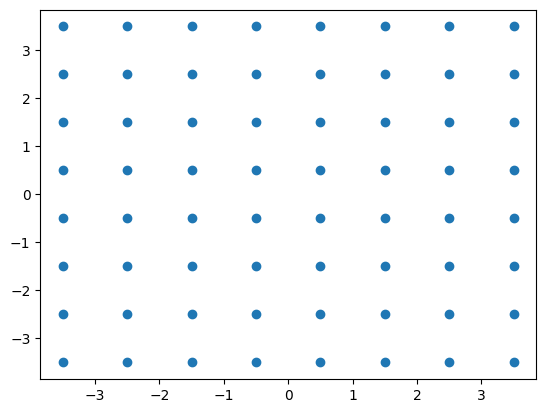

simulating LowRankCyclingRNN{N=64, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]


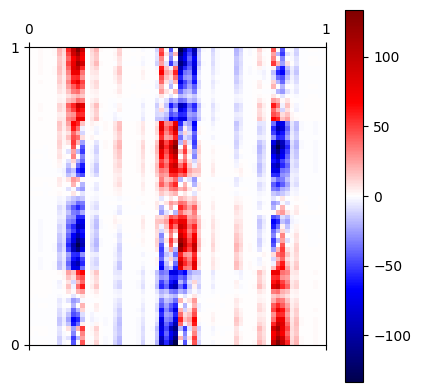

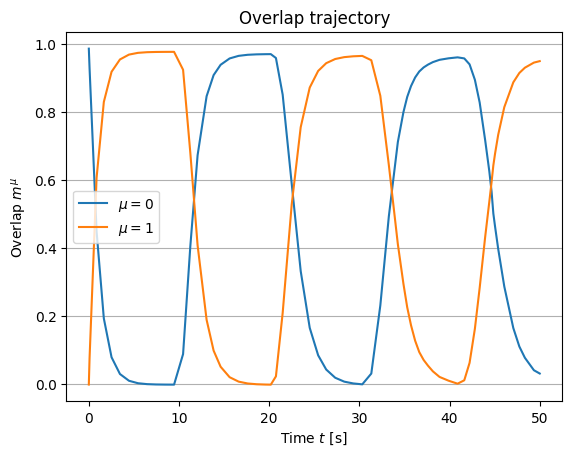

In [234]:
F_avg = np.zeros((2**nrec, 2))

for i in range(2**nrec):
	# F_avg[i] = rnn.F[i::2**nrec].mean(axis=0)
	F_avg[i] = rnn.F[i*2**nrec:(i+1)*2**nrec, :].mean(axis=0)


G_avg = np.zeros((2**nrec, 2))

for i in range(2**nrec):
	# G_avg[i] = rnn.G[i::2**nrec].mean(axis=0)
	G_avg[i] = rnn.G[i*2**nrec:(i+1)*2**nrec, :].mean(axis=0)


J_avg = np.einsum('im,jm->ij', F_avg, G_avg)

plt.scatter(*F_avg.T)
plt.show()

plt.matshow(J_avg, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
plt.colorbar()

rnn_avg = LowRankCyclingRNN(LowRankCyclingRNNParams(phi=sigmoid, I_ext=zero, exclude_self_connections=False, F=F_avg, G=G_avg, delta=10, shift=1))
res_avg = rnn_avg.simulate(h0=F_avg[:, 0], t_span=(0, 50), dt_max=1, progress=True)
plot_overlap_trajectory(rnn_avg, res_avg);

## about the reshape mapping (todo take notes)

In [18]:
params = LowRankCyclingRNNParams.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True, delta=6, shift=1)
F = params.F

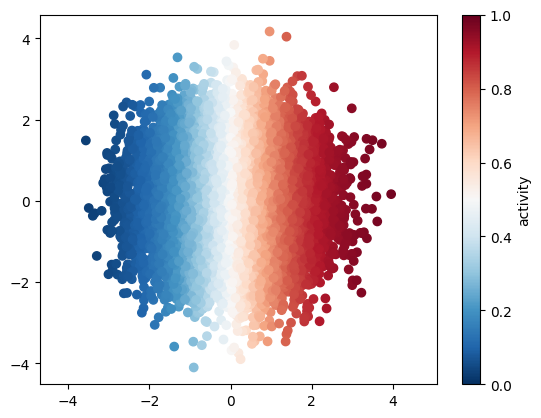

In [82]:
def fake_activity(F, n):
	# make up some overlap state m0=0.5, m1=0.5
	# this could be obtained from PCA
	n = np.array(n, dtype=float)
	n /= np.linalg.norm(n)
	return sigmoid(F.dot(n))

n = (1,0)
plt.scatter(*F.T, c=fake_activity(F, n), cmap='RdBu_r', vmin=0, vmax=1)
plt.colorbar(label='activity')
plt.axis('equal');

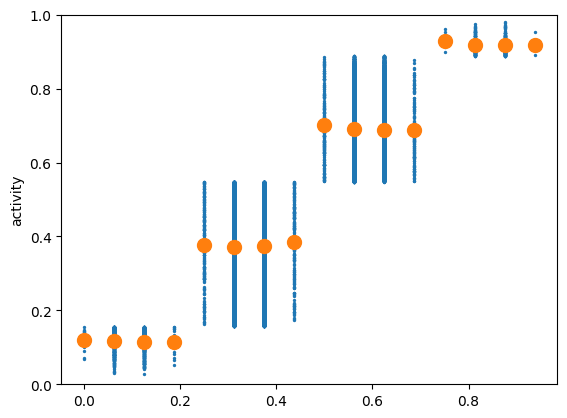

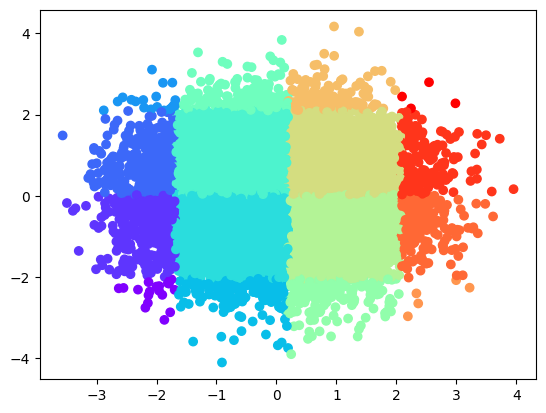

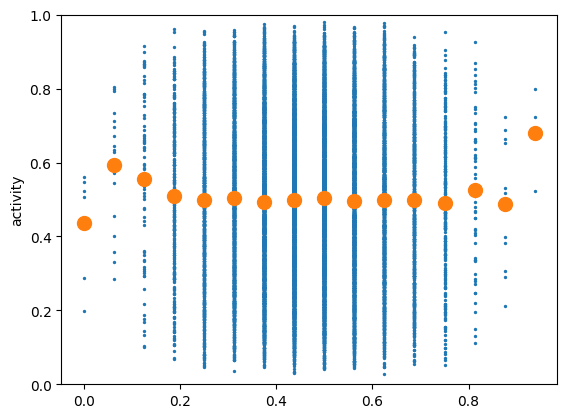

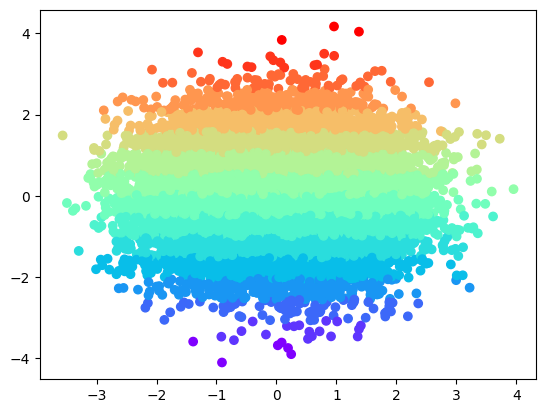

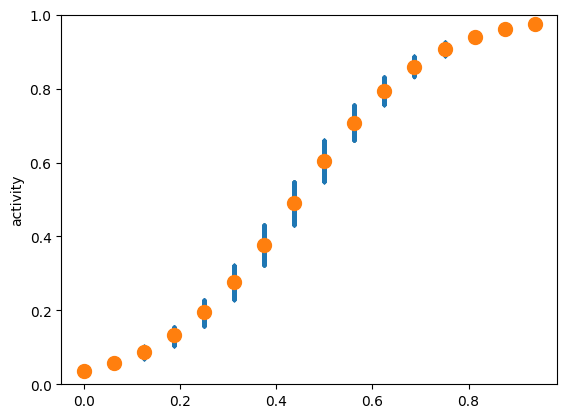

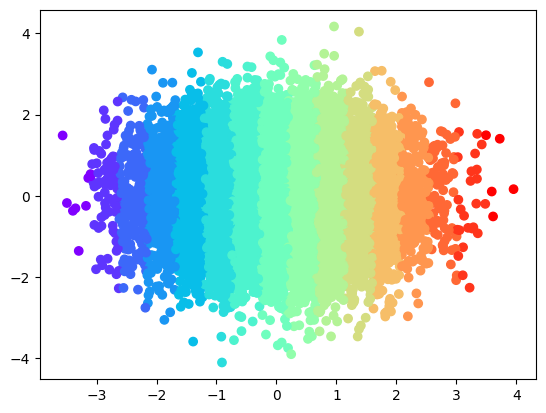

In [109]:
nrec = 2

for mapping in (ReshapeMapping(nx=2**nrec, ny=2**nrec), ReshapeMapping(nx=1, ny=4**nrec), ReshapeMapping(nx=4**nrec, ny=1)):
	print(mapping)
	values = mapping(F)
	plt.scatter(values, fake_activity(F, n), s=2)
	plt.scatter(np.linspace(0, 1-4**(-nrec), mapping.num_bins), mapping.binned_statistic(F, fake_activity(F, n), fill_na=None), s=100);
	plt.ylim((0,1))
	plt.ylabel('activity')
	plt.show()
	plt.scatter(*F.T, c=values, cmap='rainbow')
	plt.show()

1. has a gradient along x, so we get groups of 2^n bins with the same activity, but still some sigmoid, as if nx=2^n
2. has no graident along x. dynamics do not work ! -> basically projection to y axis (we are basically taking the marginal of the gaussian, integrating out the x component)
3. has only a graident along x (ny = 1). we see a nice sigmoid -> basically projection to x axis

when we average, the effect is the same as the projection along the y axis

## todo this later

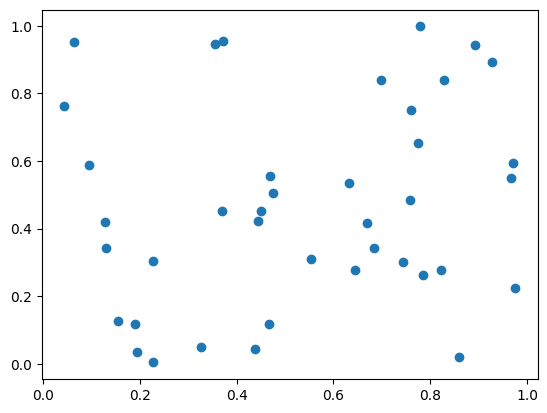

array([ 9,  1,  5, 11, 12,  5, 10,  6,  3,  2, 14, 10,  7,  6,  2,  0,  7,
       15, 10,  8,  6, 14,  9, 10, 10,  0,  1, 15,  0,  7,  6,  9,  1,  2,
       13,  0,  3, 13,  3,  7])

In [25]:
mapping = RecursiveLocalMapping(nrec=2)
F = np.zeros((40, 2))
F[:, 0] = np.random.default_rng(42).random(len(F))
F[:, 1] = np.random.default_rng(43).random(len(F))
plt.scatter(*F.T)
plt.show()
indices = mapping.indices(F)
assert (mapping.indices2d(F) == mapping.indices_to_indices2d(indices)).all()
indices

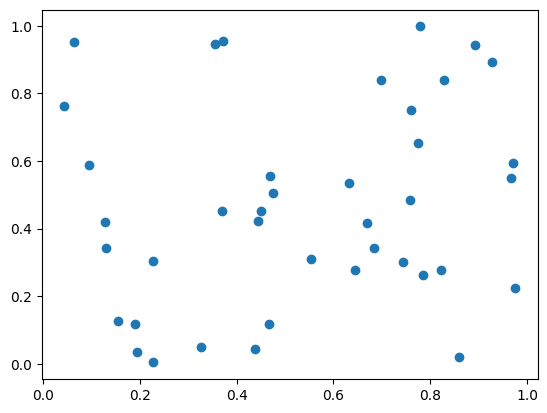

array([14,  4, 12, 11,  2, 12, 15, 13,  1,  5,  7, 15,  9, 13,  5,  0,  9,
        3, 15, 10, 13,  7, 14, 15, 15,  0,  4,  3,  0,  9, 13, 14,  4,  5,
        6,  0,  1,  6,  1,  9])

In [30]:
mapping = ReshapeMapping(nx=2**2, ny=2**2)
F = np.zeros((40, 2))
F[:, 0] = np.random.default_rng(42).random(len(F))
F[:, 1] = np.random.default_rng(43).random(len(F))
plt.scatter(*F.T)
plt.show()
indices = mapping.indices(F)
assert (mapping.indices2d(F) == mapping.indices_to_indices2d(indices)).all()
indices

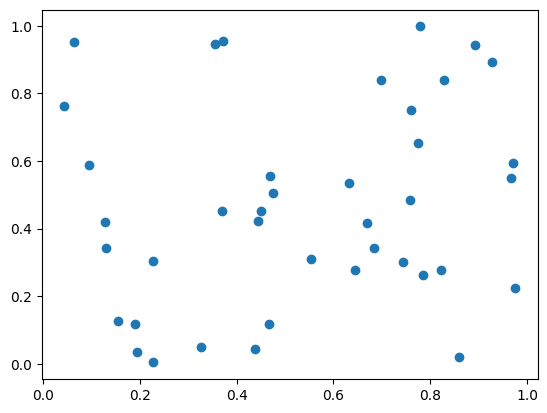

NotImplementedError: 

In [31]:
mapping = RecursiveFarMapping(nrec=2)
F = np.zeros((40, 2))
F[:, 0] = np.random.default_rng(42).random(len(F))
F[:, 1] = np.random.default_rng(43).random(len(F))
plt.scatter(*F.T)
plt.show()
indices = mapping.indices(F)
assert (mapping.indices2d(F) == mapping.indices_to_indices2d(indices)).all()
indices